<a href="https://colab.research.google.com/github/matthewjtate79/RNN-for-Stock-Prediction/blob/main/BigDataProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Matthew Tate
# MJT170000
# CS 6350.001 Final Project

In [ ]:
# The following sections get pyspark setup for our notebook
!rm -rf spark-3.1.1-bin-hadoop3.2

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q findspark pyspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession \
       .builder \
       .appName("RNN") \
       .getOrCreate()

In [ ]:
spark

In [ ]:
sc = spark.sparkContext

In [ ]:
import numpy as np

# Defines the two activation function options as well as their derivatives
def tanh(z):
    return (np.exp(z) - np.exp(-1 * z)) / (np.exp(z) + np.exp(-1 * z))

def tanh_derivative(z):
    return 1 - np.square(tanh(z))

def sigmoid(z):
    return 1 / (1 + np.exp(-1 * z))

def sigmoid_derivative(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [ ]:
# This function handles the map phase of the map-reduce process for backpropagation
def backpropagation_map(x, activation_function):
    # Organizes the results of forward propagation
    actual = x[0]
    pred = x[1]
    a = x[2]
    h_curr = x[3]
    h_prev = x[4]
    xi = x[5]
    W_h_y = x[6]

    # Computes the specific parts of the gradients
    grad_L_y = -1 * (actual - pred[0])
    grad_y_Why = a
    grad_y_By = 1
    grad_y_a = W_h_y
    if activation_function == 'tanh':
        grad_a_h = tanh_derivative(h_curr)
    else:
        grad_a_h = sigmoid_derivative(h_curr)
    grad_h_Whx = xi
    grad_h_Whh = h_prev
    grad_h_Bh = 1

    # Computes the actual gradient values
    grad_L_Whx = grad_h_Whx[:, np.newaxis] * (grad_L_y * grad_y_a * grad_a_h)
    grad_L_Bh = grad_L_y * grad_y_a * grad_a_h
    grad_L_Whh = grad_h_Whh[:, np.newaxis] * (grad_L_y * grad_y_a * grad_a_h)
    grad_L_Why = grad_L_y * grad_y_Why
    grad_L_By = grad_L_y * grad_y_By

    return (grad_L_Whx, grad_L_Bh, grad_L_Whh, grad_L_Why, grad_L_By)

# Creates a Recurrent Neural Network Model
class RNN:
    # Initializes the parameters of the model
    def __init__(self, hidden_layer_size: int, learning_rate: float, epochs: int, activation_function):
        self.hidden_layer_size = hidden_layer_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.activation_function = activation_function

        self.W_x_h = None
        self.B_h = None
        self.W_h_h = None
        self.W_h_y = None
        self.B_y = None

    # Performs a forward pass through the model for a given timestep given the input features X and results of previous timestep's activation function h_prev
    def forward_pass(self, X, h_prev):
        h_curr = X @ self.W_x_h + h_prev @ self.W_h_h + self.B_h

        if self.activation_function == 'tanh':
            a = tanh(h_curr)
        else:
            a = sigmoid(h_curr)

        pred = a @ self.W_h_y + self.B_y

        return h_curr, a, pred

    # Performs backpropagation for the entire epoch using map-reduce
    def backpropagation(self, layer_results):
        # This function receives a list of the layer results for each input and converts it into an rdd
        rdd = sc.parallelize(layer_results)

        # We then map the results into the corresponding gradients through backpropagation
        if self.activation_function == 'tanh':
            rdd1 = rdd.map(lambda x: backpropagation_map(x, 'tanh'))
        else:
            rdd1 = rdd.map(lambda x: backpropagation_map(x, 'sigmoid'))

        # Reduce phase of map-reduce combines the gradients of all timesteps into the gradients for the entire epoch
        gradients = rdd1.reduce(lambda x, y: (x[0] + y[0], x[1] + y[1], x[2] + y[2], x[3] + y[3], x[4] + y[4]))

        return gradients[0], gradients[1], gradients[2], gradients[3], gradients[4]

    # Fits the model on the training data train_X and train_y
    def fit(self, train_X, train_y):
        # Gets the size of the input
        num_features = train_X.shape[1]
        input_size = train_X.shape[0]

        # Initializes all of the weights and biases now that we know the feature size
        self.W_x_h = np.random.randn(num_features, self.hidden_layer_size)
        self.B_h = np.random.randn(self.hidden_layer_size)
        self.W_h_h = np.random.randn(self.hidden_layer_size, self.hidden_layer_size)
        self.W_h_y = np.random.randn(self.hidden_layer_size)
        self.B_y = np.array([np.random.randn()])

        # Performs forward and backpropagation for each epoch, updating weights and biases each time
        final_hidden_state = None
        for iteration in range(0, self.epochs):
            loss = 0
            layer_results = []
            h_prev = np.zeros(self.hidden_layer_size)
            for i in range(0, input_size):
                h_curr, a, pred = self.forward_pass(train_X[i], h_prev)

                # Calculate the squared loss for this iteration
                loss += 1/2 * np.square(train_y[i] - pred[0])

                # Store the results of each timestep seperately to be later provided to map-reduce function
                layer_results.append((train_y[i], pred, a, h_curr, h_prev, train_X[i], self.W_h_y))
                h_prev = a
            final_hidden_state = h_prev

            print("Epoch ", iteration+1, ": Loss = ", round(loss, 4), sep="")

            # Uses map-reduce to get the gradients for the current epoch and updates the weights/biases
            grad_L_Wxh, grad_L_Bh, grad_L_Whh, grad_L_Why, grad_L_By = self.backpropagation(layer_results)
            self.W_x_h -= self.learning_rate * grad_L_Wxh
            self.B_h -= self.learning_rate * grad_L_Bh
            self.W_h_h -= self.learning_rate * grad_L_Whh
            self.W_h_y -= self.learning_rate * grad_L_Why
            self.B_y -= self.learning_rate * grad_L_By
        return final_hidden_state

    # Given a test set test_X and the result of the last activation function from the training phase, we can predict the next stock Open prices
    def predict(self, test_X, starting_hidden_state):
        input_size = test_X.shape[0]
        predictions = np.empty(input_size)

        # Performs forward propagation for each input to generate the corresponding prediction
        h_prev = starting_hidden_state
        for i in range(0, input_size):
            h_curr, a, pred = self.forward_pass(test_X[i], h_prev)
            h_prev = a
            predictions[i] = pred[0]

        return predictions

In [ ]:
# Pipeline accepts data in the form of a numpy array with the shape (n, 1), an sklearn scaler, a RNN model, and a dictionary of parameters
def RNN_Pipeline(data, scaler, model, params):
  # PreProcess Phase -> scaler must be an sklearn scaler
  rescaled_data = scaler.fit_transform(data)
  rescaled_data = rescaled_data.reshape(len(rescaled_data),)

  # Gets the features based on window of previous Open prices
  feature_size = params['Feature Size']
  X = np.array([rescaled_data[i:i + feature_size] for i in range(len(rescaled_data) - feature_size)])
  y = rescaled_data[feature_size:]

  # Performs the train-test splits
  split_point = int(len(X) * params['Split Point'])
  starting_index = params['Starting Index']
  train_X = X[starting_index:split_point]
  train_y = y[starting_index:split_point]
  test_X = X[split_point:]
  test_y = y[split_point:]

  # Fits the given model on the preprocessed train_X and train_y
  # The fit function returns the final hidden state of the last epoch that we will use as the starting h_prev in the testing phase
  final_hidden_state = model.fit(train_X, train_y)

  # Tests the model and gets the predictions
  predictions = model.predict(test_X, final_hidden_state)

  return predictions, test_y

In [ ]:
# We use the RMSE (root mean square error) to evaluate the results of the model
def RMSE(actual, predicted, scaler):
  # We use the original scaler function from sklearn to revert the data back to original scale. It also needs to be reshaped
  unscaled_actual = scaler.inverse_transform(actual.reshape(-1, 1))
  unscaled_actual = unscaled_actual.reshape(len(unscaled_actual),)
  unscaled_predicted = scaler.inverse_transform(predicted.reshape(-1, 1))
  unscaled_predicted = unscaled_predicted.reshape(len(unscaled_predicted),)

  # Gets the RMSE and returns it along with the unscaled data
  test_size = len(unscaled_actual)
  total = 0
  for i in range(0, test_size):
    total += np.square(unscaled_actual[i] - unscaled_predicted[i])
  return round(np.sqrt(total / test_size), 4), unscaled_actual, unscaled_predicted

In [ ]:
import pandas as pd

# Reads tesla stock dataset into pandas df
df = pd.read_csv('TSLA.csv', parse_dates=True , index_col='Date')
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


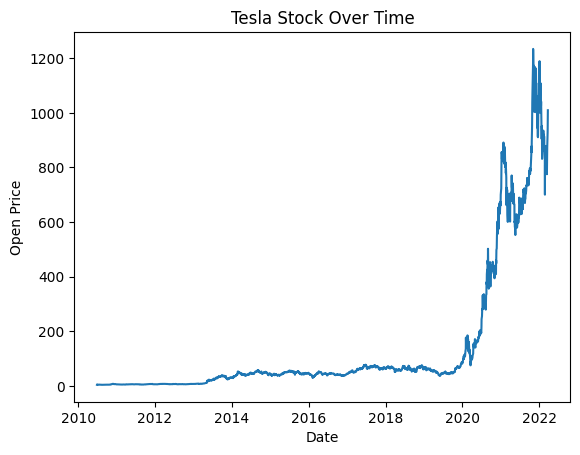

In [ ]:
import matplotlib.pyplot as plt

# Plots the stock Open prices over time
plt.plot(df.index, df['Open'])
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Tesla Stock Over Time')
plt.show()

In [ ]:
# We will use the Open Price column as our data to predict
data = df[['Open']].values
data

array([[   3.8     ],
       [   5.158   ],
       [   5.      ],
       ...,
       [ 930.      ],
       [ 979.940002],
       [1009.72998 ]])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Builds the model with custom params
model = RNN(128, 0.0001, 1000, 'tanh')
scaler = MinMaxScaler(feature_range = (0, 1))
params = {}
params['Feature Size'] = 100
params['Split Point'] = 0.98
params['Starting Index'] = 2500

# Pass the data through the pipeline to get predictions
predictions, actual = RNN_Pipeline(data, scaler, model, params)

Epoch 1: Loss = 15676.6893
Epoch 2: Loss = 28362.4767
Epoch 3: Loss = 46723.5728
Epoch 4: Loss = 59156.4679
Epoch 5: Loss = 53771.2649
Epoch 6: Loss = 36376.8156
Epoch 7: Loss = 19567.9801
Epoch 8: Loss = 11605.3344
Epoch 9: Loss = 7616.1936
Epoch 10: Loss = 5849.0472
Epoch 11: Loss = 5166.5102
Epoch 12: Loss = 4329.5637
Epoch 13: Loss = 5112.6701
Epoch 14: Loss = 3608.8085
Epoch 15: Loss = 3892.6239
Epoch 16: Loss = 3013.539
Epoch 17: Loss = 2952.4028
Epoch 18: Loss = 2823.6579
Epoch 19: Loss = 2887.8807
Epoch 20: Loss = 2792.5917
Epoch 21: Loss = 2876.613
Epoch 22: Loss = 2588.9333
Epoch 23: Loss = 2690.5196
Epoch 24: Loss = 2852.3674
Epoch 25: Loss = 2014.9827
Epoch 26: Loss = 2030.727
Epoch 27: Loss = 2234.5665
Epoch 28: Loss = 1990.7257
Epoch 29: Loss = 1982.0608
Epoch 30: Loss = 1842.7479
Epoch 31: Loss = 1713.072
Epoch 32: Loss = 2194.4184
Epoch 33: Loss = 2139.7508
Epoch 34: Loss = 1896.232
Epoch 35: Loss = 1546.6304
Epoch 36: Loss = 1452.127
Epoch 37: Loss = 1428.6237
Epoch 38

In [ ]:
# Gets RMSE for the predictions
rmse, unscaled_actual, unscaled_predicted = RMSE(actual, predictions, scaler)
print("RMSE:", round(rmse, 4))

RMSE: 202.5113


In [ ]:
# Compares predictions with the actual data
for i in range(0, len(unscaled_actual)):
  print("Actual: ", round(unscaled_actual[i], 2), " , Predicted: ", round(unscaled_predicted[i], 2), sep="")

Actual: 1073.44 , Predicted: 894.25
Actual: 1147.75 , Predicted: 798.03
Actual: 1189.55 , Predicted: 841.64
Actual: 1146.65 , Predicted: 828.25
Actual: 1077.0 , Predicted: 762.96
Actual: 1080.37 , Predicted: 902.8
Actual: 1000.0 , Predicted: 616.02
Actual: 1053.67 , Predicted: 889.31
Actual: 1078.85 , Predicted: 790.83
Actual: 1109.07 , Predicted: 730.98
Actual: 1019.88 , Predicted: 754.06
Actual: 1026.61 , Predicted: 730.05
Actual: 1041.71 , Predicted: 760.63
Actual: 1009.73 , Predicted: 913.93
Actual: 996.34 , Predicted: 740.12
Actual: 904.76 , Predicted: 709.7
Actual: 914.2 , Predicted: 777.77
Actual: 952.43 , Predicted: 791.26
Actual: 933.36 , Predicted: 712.36
Actual: 831.56 , Predicted: 926.51
Actual: 872.71 , Predicted: 801.54
Actual: 935.21 , Predicted: 768.91
Actual: 928.18 , Predicted: 793.77
Actual: 882.0 , Predicted: 913.99
Actual: 897.22 , Predicted: 811.07
Actual: 923.79 , Predicted: 859.32
Actual: 905.53 , Predicted: 771.81
Actual: 935.0 , Predicted: 679.37
Actual: 908.3

Text(0.5, 1.0, 'Comparison of Actual and Predicted Open Prices')

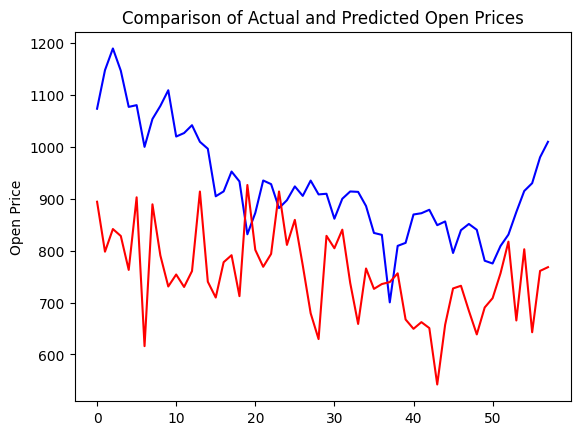

In [ ]:
# Plots the actual prices and predicted prices against each other

# Gets the indices for the x-axis
indices = np.arange(len(unscaled_actual))

# Plots the two np arrays
plt.plot(indices, unscaled_actual, label="Actual Prices", color='blue')  # Plot array1 in blue
plt.plot(indices, unscaled_predicted, label="Predicted Prices", color='red')  # Plot array2 in red
plt.xlabel("")
plt.ylabel("Open Price")
plt.title("Comparison of Actual and Predicted Open Prices")

In [ ]:
import pandas as pd

# Reads coca cola stock dataset into pandas df
df = pd.read_csv('Coca-Cola_stock_history.csv', parse_dates=True , index_col='Date')
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1962-01-02,0.050016,0.051378,0.050016,0.050016,806400,0.0,0
1962-01-03,0.049273,0.049273,0.048159,0.048902,1574400,0.0,0
1962-01-04,0.049026,0.049645,0.049026,0.049273,844800,0.0,0
1962-01-05,0.049273,0.049892,0.048035,0.048159,1420800,0.0,0
1962-01-08,0.047787,0.047787,0.046735,0.047664,2035200,0.0,0


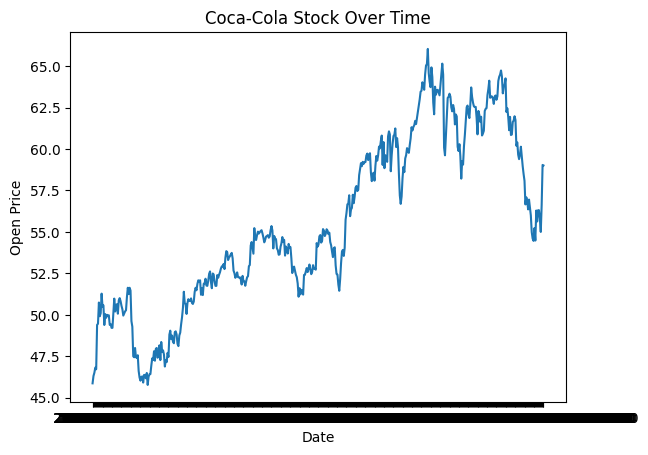

In [ ]:
import matplotlib.pyplot as plt

# Plots the stock Open prices over time
temp = df.tail(500)
plt.plot(temp.index, temp['Open'])
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Coca-Cola Stock Over Time')
plt.show()

In [ ]:
# We will use the Open Price column as our data to predict
data = df[['Open']].values
data

array([[5.00159190e-02],
       [4.92731520e-02],
       [4.90255600e-02],
       ...,
       [5.66399994e+01],
       [5.90400009e+01],
       [5.90099983e+01]])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Builds the model with custom params
model = RNN(64, 0.000005, 2500, 'tanh')
scaler = MinMaxScaler(feature_range = (0, 1))
params = {}
params['Feature Size'] = 50
params['Split Point'] = 0.99
params['Starting Index'] = 13000

# Pass the data through the pipeline to get predictions
predictions, actual = RNN_Pipeline(data, scaler, model, params)

Epoch 1: Loss = 41267.6148
Epoch 2: Loss = 27617.2912
Epoch 3: Loss = 25530.9645
Epoch 4: Loss = 24620.578
Epoch 5: Loss = 22085.6639
Epoch 6: Loss = 22656.9597
Epoch 7: Loss = 20787.8217
Epoch 8: Loss = 20581.0705
Epoch 9: Loss = 20232.6482
Epoch 10: Loss = 18939.1777
Epoch 11: Loss = 18598.8676
Epoch 12: Loss = 17494.6641
Epoch 13: Loss = 18220.3636
Epoch 14: Loss = 16885.7047
Epoch 15: Loss = 17123.9004
Epoch 16: Loss = 15758.3704
Epoch 17: Loss = 14895.1372
Epoch 18: Loss = 14000.558
Epoch 19: Loss = 14801.7692
Epoch 20: Loss = 14352.0559
Epoch 21: Loss = 13628.6715
Epoch 22: Loss = 13107.9378
Epoch 23: Loss = 13065.4505
Epoch 24: Loss = 13002.8575
Epoch 25: Loss = 11874.311
Epoch 26: Loss = 11658.0382
Epoch 27: Loss = 11844.3085
Epoch 28: Loss = 11907.2881
Epoch 29: Loss = 11862.4785
Epoch 30: Loss = 10882.9217
Epoch 31: Loss = 10551.2647
Epoch 32: Loss = 10781.5535
Epoch 33: Loss = 10297.3666
Epoch 34: Loss = 10626.008
Epoch 35: Loss = 9175.7357
Epoch 36: Loss = 9069.7361
Epoch 3

In [ ]:
# Gets RMSE for the predictions
rmse, unscaled_actual, unscaled_predicted = RMSE(actual, predictions, scaler)
print("RMSE:", round(rmse, 4))

RMSE: 12.1133


In [ ]:
# Compares predictions with the actual data
for i in range(0, len(unscaled_actual)):
  print("Actual: ", round(unscaled_actual[i], 2), " , Predicted: ", round(unscaled_predicted[i], 2), sep="")

Actual: 59.63 , Predicted: 50.13
Actual: 60.06 , Predicted: 45.08
Actual: 59.88 , Predicted: 52.13
Actual: 59.77 , Predicted: 41.58
Actual: 60.24 , Predicted: 44.3
Actual: 60.65 , Predicted: 52.48
Actual: 61.32 , Predicted: 49.09
Actual: 61.12 , Predicted: 48.07
Actual: 61.33 , Predicted: 49.64
Actual: 61.43 , Predicted: 54.81
Actual: 61.7 , Predicted: 56.25
Actual: 61.5 , Predicted: 49.07
Actual: 61.87 , Predicted: 50.68
Actual: 62.22 , Predicted: 52.49
Actual: 62.57 , Predicted: 50.91
Actual: 62.99 , Predicted: 72.09
Actual: 63.46 , Predicted: 47.52
Actual: 63.51 , Predicted: 47.28
Actual: 64.03 , Predicted: 49.16
Actual: 63.84 , Predicted: 52.58
Actual: 63.57 , Predicted: 50.1
Actual: 64.5 , Predicted: 51.8
Actual: 65.03 , Predicted: 51.92
Actual: 65.13 , Predicted: 54.69
Actual: 66.04 , Predicted: 52.01
Actual: 64.58 , Predicted: 52.79
Actual: 64.07 , Predicted: 54.24
Actual: 63.73 , Predicted: 49.9
Actual: 64.92 , Predicted: 49.26
Actual: 64.34 , Predicted: 44.33
Actual: 62.81 , P

Text(0.5, 1.0, 'Comparison of Actual and Predicted Open Prices')

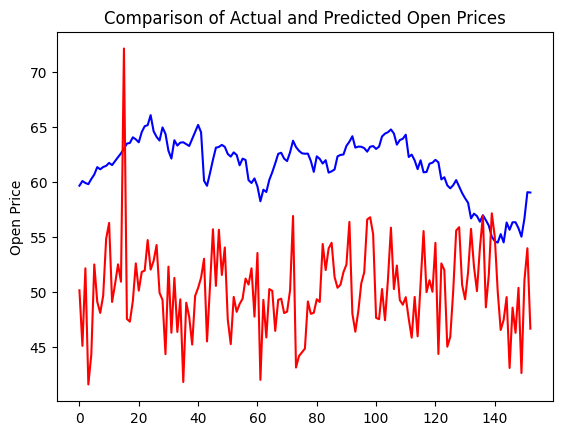

In [ ]:
# Plots the actual prices and predicted prices against each other

# Gets the indices for the x-axis
indices = np.arange(len(unscaled_actual))

# Plots the two np arrays
plt.plot(indices, unscaled_actual, label="Actual Prices", color='blue')  # Plot array1 in blue
plt.plot(indices, unscaled_predicted, label="Predicted Prices", color='red')  # Plot array2 in red
plt.xlabel("")
plt.ylabel("Open Price")
plt.title("Comparison of Actual and Predicted Open Prices")